# N05: Gap-Based Strategy Rules for F1

## 1. Introduction and Objective


Gap analysis is a critical component of Formula 1 race strategy. The time difference between cars (measured in seconds) directly influences strategic decisions like undercuts, overcuts, and defensive pit stops. This notebook implements rules that use these gaps to make strategic recommendations.


### Why Gap Analysis Matters

* **Undercut Opportunities:** When a car is close behind another (~1-2s), pitting earlier might allow overtaking through fresher tires
* **Overcut Potential:** Sometimes staying out longer works better, especially when the leading car has clean air
* **Defensive Strategy**: Teams must react when competitors attempt undercuts
* **Traffic Management**: Gaps determine whether a car will exit the pits into free air or traffic

### Our Objectives

Extract and process gap data from FastF1 (replacing our previous computer vision approach)
Analyze gap distributions to establish meaningful thresholds for strategic decisions
Implement four key rules:

1. **Undercut Opportunity Rule**: Identify when an undercut might succeed
2. **Defensive Pit Stop Rule**: Protect position against undercut attempts
3. **Overcut Strategy Rule:** Recognize when staying out longer is advantageous
4. **Traffic Management Rule**: Avoid exiting pit stops into traffic



These rules will complement our existing components (tire degradation, lap time analysis, and radio communication) to create a comprehensive F1 strategy system.

---

## What is an undercut or an overcut?

In this section, I will make an explanation of these two concepts, enhancing the explanation with two posters made with ChatGPT (they have some spelling mistakes but still provide good explanations).

<p float="left">
  <img src="images/undercut_poster.png" alt="Undercut Image" width="40%" style="margin-right: 10px;">
  <img src="images/overcut_poster.png" alt="Overcut Image" width="40%">
</p>


### Undercut

The F1 undercut is a strategic maneuver that can change the course of a race. When the chasing car is within about three seconds of the leader, the leader may choose to enter the pit lane early to switch to fresh tires.

Although this pit stop costs roughly 20–23 seconds, the significant performance boost from the fresh tires allows the leader to complete laps much faster than the car still running on worn tires. By the time the chaser paces into its own pit stop, the leader has gained enough of a time advantage to overtake on track. 

This short-term benefit—gaining extra pace due to better tire grip—is critical on circuits with high tire degradation, such as Barcelona.


### Overcut

In contrast, the overcut is a similar concept with an opposite approach. Rather than pitting early, a driver using the overcut strategy remains on the track with worn tires for a longer period while the competitors pit.

If the driver can maintain competitive lap times despite the older rubber—or if the competitors’ new tires take extra time to warm up—the longer stint can yield a time advantage. Once the rival makes its pit stop, the overcutting driver then pits later and, thanks to having run a more consistent pace in clean air, can gain positions on the circuit.




In [1]:
__author__ = "Víctor Vega Sobral"

---

In [2]:
# Standard data processing libraries
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical operations
import matplotlib.pyplot as plt  # For creating visualizations
import seaborn as sns            # For enhanced visualizations
from datetime import datetime, timedelta    # For timestamp handling
import os                        # For operating system interactions
import sys                       # For system-specific parameters and functions
import requests
# Add parent directory to system path to make custom modules accessible
sys.path.append(os.path.abspath('../'))
import fastf1


# Import Experta components for building the rule engine
from experta import Rule, NOT, OR, AND, AS, MATCH, TEST, EXISTS  # Rule definition components
from experta import DefFacts, Fact, Field, KnowledgeEngine      # Core Experta classes
fastf1.Cache.enable_cache('../../f1-strategy/f1_cache')


from utils.N01_agent_setup import (
        TelemetryFact,              # For storing car performance data
        DegradationFact,            # For storing tire degradation information
        GapFact,                    # For storing gap information
        RaceStatusFact,             # For storing current race conditions
        StrategyRecommendation,     # For storing strategy recommendations
        F1StrategyEngine,           # Base engine class
        transform_gap_data_with_consistency,         # Function to convert gap data to facts
        load_gap_data,               # Function to load gap data from FastF1
        calculate_gap_consistency
)


# Configure plotting style for better visualization
plt.style.use('seaborn-v0_8-darkgrid')  # Set default plot style
sns.set_context("notebook", font_scale=1.2)  # Increase font size slightly

print("Libraries and fact classes loaded successfully.")

Engine initialized with 2 facts
Initial facts: [InitialFact(), RaceStatusFact(lap=1, total_laps=60, race_phase='start', track_status='clear')]

=== TIRE DEGRADATION ANALYSIS ===
Using first predicted rate as current degradation: 0.07
Tire facts declared: {'degradation': DegradationFact(degradation_rate=0.07, predicted_rates=frozenlist([0.07, 0.09, 0.12])), 'telemetry': TelemetryFact(tire_age=4, compound_id=2, driver_number=44, position=1)}
Engine now has 4 facts

=== LAP TIME PREDICTION ===
Lap time facts declared: {'telemetry': TelemetryFact(driver_number=44, lap_time=80.3, predicted_lap_time=79.9, compound_id=2, tire_age=4, position=1)}
Engine now has 5 facts

=== RADIO ANALYSIS ===
Radio fact declared: <f-5>
Engine now has 6 facts

=== ALL ENGINE FACTS ===
Fact 1: InitialFact - <f-0>
Fact 2: RaceStatusFact - <f-1>
Fact 3: DegradationFact - <f-2>
Fact 4: TelemetryFact - <f-3>
Fact 5: TelemetryFact - <f-4>
Fact 6: RadioFact - <f-5>
Libraries and fact classes loaded successfully.


---

## 2. Data Extraction and Processing

### 2.1 Loading session and lap data

In [3]:
# ------------------------------------------------------------------------------------
# LOAD SESSION DATA
# ------------------------------------------------------------------------------------
# Loading the session data for the Spanish Grand Prix 2023 (Race)
print("Loading the Spanish Grand Prix 2023 session data...")
race = fastf1.get_session(2023, 'Spain', 'R')
# The .load() method fetches basic session details, including lap times and more
race.load()

# ------------------------------------------------------------------------------------
# LOAD LAP DATA
# ------------------------------------------------------------------------------------
# Retrieving lap data from the session. This is automatically loaded when calling race.load()
print("Loading lap data...")
laps_data = race.laps
# Print the number of lap entries loaded
print(f"Loaded {len(laps_data)} lap entries")

# Note:
# We no longer use race.api.timing_data because all necessary timing data is now available directly from laps_data.

# ------------------------------------------------------------------------------------
# DEFINE FUNCTION: GET GAP AT LAP COMPLETION
# ------------------------------------------------------------------------------------
def get_gap_at_lap_completion(driver, lap_number, laps_data):
    """
    Calculates the gap to the leader for a given driver at the moment they complete a lap.
    It is computed by comparing the lap completion time ('Time') of the driver with the leader's
    completion time (minimum 'Time' of that lap).

    Args:
        driver (str): Abbreviation for the driver.
        lap_number (int): The lap number to analyze.
        laps_data (DataFrame): The lap data from FastF1.

    Returns:
        float or None: The gap to the leader in seconds, or None if the information is missing.
    """
    # Filter the lap data for the specific driver and lap number
    driver_lap = laps_data[(laps_data['Driver'] == driver) & (laps_data['LapNumber'] == lap_number)]
    if driver_lap.empty:
        # If no data is found for the given driver and lap, return None
        return None

    # Get the completion time of this lap for the driver
    driver_finish_time = driver_lap.iloc[0]['Time']

    # For the specified lap, find the fastest (leader) lap completion time
    lap_group = laps_data[laps_data['LapNumber'] == lap_number]
    leader_time = lap_group['Time'].min()

    # Compute the gap by calculating the time difference between the driver's finish time and the leader's finish time
    gap_to_leader = driver_finish_time - leader_time
    # Convert the gap to seconds if gap_to_leader is a timedelta object
    if hasattr(gap_to_leader, 'total_seconds'):
        gap_to_leader = gap_to_leader.total_seconds()
    return gap_to_leader



Loading the Spanish Grand Prix 2023 session data...


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.1.6]
INFO:fastf1.fastf1.core:Loading data for Spanish Grand Prix - Race [v3.1.6]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

Loading lap data...
Loaded 1312 lap entries


---

### 2.2 Calculate all gaps

In [4]:
# ------------------------------------------------------------------------------------
# DEFINE FUNCTION: CALCULATE ALL GAPS
# ------------------------------------------------------------------------------------
def calculate_all_gaps(laps_data):
    """
    Calculates the gaps for all drivers at the completion of each lap.

    Args:
        laps_data (DataFrame): Lap data from FastF1 or another source

    Returns:
        DataFrame: Processed gap data with all calculated metrics
    """
    gap_results = []

    # Check if we need to use 'DriverNumber' instead of 'Driver'
    driver_column = 'Driver' if 'Driver' in laps_data.columns else 'DriverNumber'

    print(f"Using '{driver_column}' as driver identifier column")

    # Get unique drivers and sorted lap numbers from the lap data
    drivers = laps_data[driver_column].unique()
    lap_numbers = sorted(laps_data['LapNumber'].unique(
    )) if 'LapNumber' in laps_data.columns else sorted(laps_data['TyreAge'].unique())
    lap_column = 'LapNumber' if 'LapNumber' in laps_data.columns else 'TyreAge'

    print(
        f"Processing gaps for {len(drivers)} drivers across {len(lap_numbers)} laps using '{lap_column}' column...")

    # Function to get the gap at lap completion
    def get_gap_at_lap_completion(driver_id, lap_num):
        # Filter for specific driver and lap
        driver_lap = laps_data[(laps_data[driver_column] == driver_id) & (
            laps_data[lap_column] == lap_num)]
        if driver_lap.empty:
            return None

        # Get reference time - either 'Time' column or calculated from 'LapTime'
        if 'Time' in driver_lap.columns:
            driver_finish_time = driver_lap.iloc[0]['Time']
        elif 'LapTime' in driver_lap.columns:
            # If we only have lap time, use that as a proxy
            driver_finish_time = driver_lap.iloc[0]['LapTime']
        else:
            return None

        # Get all laps at this lap number
        lap_group = laps_data[laps_data[lap_column] == lap_num]

        # Get minimum time for this lap (leader's time)
        if 'Time' in lap_group.columns:
            leader_time = lap_group['Time'].min()
        elif 'LapTime' in lap_group.columns:
            leader_time = lap_group['LapTime'].min()
        else:
            return None

        # Calculate gap to leader
        gap_to_leader = driver_finish_time - leader_time

        # Handle timedelta objects if needed
        if hasattr(gap_to_leader, 'total_seconds'):
            gap_to_leader = gap_to_leader.total_seconds()

        return gap_to_leader

    # Process each lap
    for lap_num in lap_numbers:
        print(f"Processing lap {lap_num}...", end='\r')

        # Dictionary to store gap to leader for each driver
        lap_positions = {}

        # Calculate gap to leader for each driver
        for driver in drivers:
            gap_to_leader = get_gap_at_lap_completion(driver, lap_num)
            if gap_to_leader is not None:
                lap_positions[driver] = gap_to_leader

        # Sort drivers by gap to leader
        sorted_drivers = sorted(lap_positions.items(), key=lambda x: x[1])

        # For each driver, calculate additional gap metrics
        for i, (driver, gap_to_leader) in enumerate(sorted_drivers):
            # Get driver info (driver number and team)
            driver_info = laps_data[laps_data[driver_column] == driver].iloc[0]

            # Initialize default values
            driver_number = driver
            if driver_column == 'Driver' and 'DriverNumber' in driver_info:
                driver_number = driver_info['DriverNumber']

            # Initialize gap values
            gap_ahead = None
            car_ahead = None
            gap_behind = None
            car_behind = None
            car_ahead_number = None
            car_behind_number = None

            # Calculate gap to car ahead
            if i > 0:
                car_ahead = sorted_drivers[i-1][0]
                gap_ahead = gap_to_leader - sorted_drivers[i-1][1]

                # Get car ahead number
                if car_ahead in laps_data[driver_column].values:
                    car_ahead_info = laps_data[laps_data[driver_column]
                                               == car_ahead].iloc[0]
                    if driver_column == 'Driver' and 'DriverNumber' in car_ahead_info:
                        car_ahead_number = car_ahead_info['DriverNumber']
                    else:
                        car_ahead_number = car_ahead

            # Calculate gap to car behind
            if i < len(sorted_drivers) - 1:
                car_behind = sorted_drivers[i+1][0]
                gap_behind = sorted_drivers[i+1][1] - gap_to_leader

                # Get car behind number
                if car_behind in laps_data[driver_column].values:
                    car_behind_info = laps_data[laps_data[driver_column]
                                                == car_behind].iloc[0]
                    if driver_column == 'Driver' and 'DriverNumber' in car_behind_info:
                        car_behind_number = car_behind_info['DriverNumber']
                    else:
                        car_behind_number = car_behind

            # Create result entry
            gap_results.append({
                'LapNumber': lap_num,
                'Driver': driver,
                'DriverNumber': driver_number,
                'Position': i + 1,  # Position is 1-indexed
                'GapToLeader': gap_to_leader,
                'CarAhead': car_ahead,
                'CarAheadNumber': car_ahead_number,
                'GapToCarAhead': gap_ahead,
                'CarBehind': car_behind,
                'CarBehindNumber': car_behind_number,
                'GapToCarBehind': gap_behind,
                'InUndercutWindow': gap_ahead is not None and gap_ahead < 2.5,
                'InDRSWindow': gap_ahead is not None and gap_ahead < 1.0
            })

    print("\nProcessing complete!")
    return pd.DataFrame(gap_results)




---

### 2.3 Calculate gaps using only lap data

In [5]:
# ------------------------------------------------------------------------------------
# CALCULATE GAPS USING ONLY LAP DATA
# ------------------------------------------------------------------------------------
print("Calculating gaps at lap completion points...")
all_gaps_df = calculate_all_gaps(laps_data)

# ------------------------------------------------------------------------------------
# ADD ADDITIONAL DRIVER INFORMATION
# ------------------------------------------------------------------------------------
# Create a mapping for each driver to include additional information (e.g., car number, team)
driver_info = {}
for _, lap in laps_data.iterrows():
    driver = lap['Driver']
    # Ensure the driver has an entry in the dictionary
    if driver not in driver_info:
        driver_info[driver] = {
            'DriverNumber': lap['DriverNumber'],
            'Team': lap['Team']
        }

# Map the 'Team' information to the gap DataFrame using the driver mapping
all_gaps_df['Team'] = all_gaps_df['Driver'].map(lambda x: driver_info.get(x, {}).get('Team', 'Unknown'))

Calculating gaps at lap completion points...
Using 'Driver' as driver identifier column
Processing gaps for 20 drivers across 66 laps using 'LapNumber' column...
Processing lap 66.0...
Processing complete!


---

### 2.4 Basic statistics and csv output

In [6]:
# ------------------------------------------------------------------------------------
# BASIC STATISTICS AND CSV OUTPUT FOR GAP DATA
# ------------------------------------------------------------------------------------

# Print basic statistics regarding the gap data
print("\nBasic statistics on gap data:")

# Total number of gap records in the DataFrame
print(f"Total gap records: {len(all_gaps_df)}")
# The number of unique laps covered in the DataFrame
print(f"Number of laps covered: {all_gaps_df['LapNumber'].nunique()}")
# The number of unique drivers in the DataFrame
print(f"Number of drivers: {all_gaps_df['Driver'].nunique()}")

# ------------------------------------------------------------------------------------
# CALCULATE PERCENTAGE STATISTICS FOR STRATEGIC WINDOWS
# ------------------------------------------------------------------------------------
# Calculate the percentage of records where the gap ahead is less than 2.5 seconds,
# which could indicate an undercut opportunity
undercut_pct = all_gaps_df['InUndercutWindow'].mean() * 100

# Calculate the percentage of records where the gap ahead is less than 1.0 second,
# which may indicate eligibility for DRS
drs_pct = all_gaps_df['InDRSWindow'].mean() * 100

# Print the calculated percentages with one decimal place
print(f"\nPercentage of gaps in undercut window (<2.5s): {undercut_pct:.1f}%")
print(f"Percentage of gaps in DRS window (<1.0s): {drs_pct:.1f}%")

# ------------------------------------------------------------------------------------
# SUMMARY STATISTICS FOR THE GAP TO THE CAR AHEAD
# ------------------------------------------------------------------------------------
# Print summary statistics (e.g., count, mean, std, etc.) for the 'GapToCarAhead' column
print("\nSummary statistics for Gap To Car Ahead (seconds):")
print(all_gaps_df['GapToCarAhead'].describe())
missing_counts = all_gaps_df.isnull().sum()
print(missing_counts)



Basic statistics on gap data:
Total gap records: 1312
Number of laps covered: 66
Number of drivers: 20

Percentage of gaps in undercut window (<2.5s): 44.8%
Percentage of gaps in DRS window (<1.0s): 16.5%

Summary statistics for Gap To Car Ahead (seconds):
count    1246.000000
mean        4.420835
std         4.707452
min         0.093000
25%         1.331250
50%         2.751000
75%         5.667250
max        39.657000
Name: GapToCarAhead, dtype: float64
LapNumber            0
Driver               0
DriverNumber         0
Position             0
GapToLeader          0
CarAhead            66
CarAheadNumber      66
GapToCarAhead       66
CarBehind           66
CarBehindNumber     66
GapToCarBehind      66
InUndercutWindow     0
InDRSWindow          0
Team                 0
dtype: int64


---

### 2.5 Filling missing values

In [7]:
# ------------------------------------------------------------------------------------
# FILLING MISSING VALUES FOR LEADER AND LAST POSITION
# ------------------------------------------------------------------------------------
# For the leader, there is no car ahead; therefore, fill the missing values with 'Leader'
all_gaps_df['CarAhead'] = all_gaps_df['CarAhead'].fillna('Leader')
all_gaps_df['CarAheadNumber'] = all_gaps_df['CarAheadNumber'].fillna('Leader')
# Also, fill the missing gap value with 0 seconds, as the leader has no gap to a car ahead
all_gaps_df['GapToCarAhead'] = all_gaps_df['GapToCarAhead'].fillna(0)

# For the last position, there is no car behind; fill the missing values with 'Tail'
all_gaps_df['CarBehind'] = all_gaps_df['CarBehind'].fillna('Tail')
all_gaps_df['CarBehindNumber'] = all_gaps_df['CarBehindNumber'].fillna('Tail')
# Similarly, fill the missing gap value for the car behind with 0 seconds
all_gaps_df['GapToCarBehind'] = all_gaps_df['GapToCarBehind'].fillna(0)

# ------------------------------------------------------------------------------------
# EXPORT THE PROCESSED DATA TO A CSV FILE
# ------------------------------------------------------------------------------------
# Save the processed gap data to a CSV file
# The 'float_format' argument ensures all floats are formatted to 3 decimal places
all_gaps_df.to_csv("../../f1-strategy/data/processed/gaps_spain_data.csv", float_format="%.3f")

---

## Gap Data Processing: Summary and Next Steps

### What We've Accomplished

- **Data Extraction**
  - Loaded 2023 Spanish Grand Prix lap data with FastF1.
  - Implemented precise gap calculation at each lap completion.
  - Computed key metrics: gap to leader, gap to car ahead, and gap to car behind.

- **Strategic Metrics**
  - Added strategic flags: undercut window (gap < 2.5s) and DRS window (gap < 1.0s).
  - Calculated percentages for strategic opportunities.
  - Generated comprehensive statistics on gap distributions.

- **Data Cleaning**
  - Identified and filled missing values with appropriate placeholders.
  - Marked the leader (no car ahead) and the last position (no car behind).
  - Created a clean dataset ready for rule implementation.

- **Data Persistence**
  - Saved the processed gap data to CSV with consistent formatting.
  - Ensured the data is structured for integration with our expert system.

### Next Steps

- **Gap-Based Rule Implementation**
  - Define a `F1GapRules` class inheriting from `F1StrategyEngine` (similar to the approach in N04 for radio communication rules).
  - Implement four key strategic rules:
    - **Undercut Opportunity Rule:** Recommend early pit stops when following closely (e.g., `GapToCarAhead < 2.5s` along with favorable conditions like tire age and degradation).
    - **Defensive Pit Stop Rule:** Recommend defensive actions when being closely followed (e.g., when `GapToCarBehind < 2.5s` and the gap is decreasing).
    - **Overcut Strategy Rule:** Suggest staying out longer in clean air when leading cars pit.
    - **Traffic Management Rule:** Use gap data to predict post-pit positions and avoid pitting into traffic.

- **Testing and Integration**
  - Create a testing framework (similar to `test_radio_rules` in N04) to validate each rule using processed gap data.
  - Combine these rules with tire degradation (N02), lap time (N03), and radio rules (N04).
  - Implement conflict resolution and adjust priorities based on the reliability and importance of different data sources.

These gap-based rules will complete our strategic decision support system by addressing the critical aspect of relative positioning and the strategic opportunities it creates during races.


---

## 3. Defining the gap rules


In this section, we'll implement rules that analyze the time gaps between cars to make strategic recommendations. These gap-based rules are critical for:

1. **Identifying Undercut Opportunities**: When a car should pit early to gain track position
2. **Defensive Strategy**: When a car should respond to potential undercuts from behind
3. **Overcut Potential**: When staying out longer on old tires might be advantageous
4. **Traffic Management**: Avoiding exiting the pits into slower traffic

Gap analysis is one of the most important aspects of F1 strategy, as positions are often gained and lost through pit stop timing rather than on-track overtaking, especially on circuits where passing is difficult.

Our implementation will follow the same pattern as our other rule components, with gap data being processed into GapFact objects that our rules will then analyze.

### 3.1 Description of Gap-Based Rules

#### Rule 1: Undercut Opportunity
- **Condition**: Gap to car ahead < 2.0s AND consistently in this window for at least 3 consecutive laps AND current lap within strategic windows (laps 6-26 or 26-48)
- **Action**: Recommend performing an undercut (pitting before the car ahead)
- **Rationale**: When following closely for multiple laps but unable to overtake, fresh tires can provide enough performance advantage to pass after the other car pits
- **Confidence**: 0.85 (85%)

#### Rule 2: Defensive Pit Stop
- **Condition**: Gap to car behind < 2.0s AND consistently in this window for at least 3 consecutive laps AND current lap within strategic windows (laps 6-26 or 26-48)
- **Action**: Recommend a defensive pit stop to protect position
- **Rationale**: When being closely followed by a faster car for several laps, pitting first prevents being undercut
- **Confidence**: 0.8 (80%)

#### Rule 3: Strategic Overcut
- **Condition**: Gap to car ahead between 2.0s and 3.5s AND consistently in this window for at least 4 consecutive laps AND current lap within strategic windows (laps 6-26 or 26-48)
- **Action**: Recommend staying out longer (overcut strategy)
- **Rationale**: When consistently in the overcut range, staying out while others pit can gain track position
- **Confidence**: 0.8 (80%)

#### Rule 4: Traffic Management
- **Condition**: Position > 10 AND gap to leader > 30.0s AND current lap within strategic windows (laps 6-26 or 26-48)
- **Action**: Recommend adjusting pit window to avoid traffic
- **Rationale**: For cars in the middle/back of the pack, optimizing traffic patterns can save significant race time
- **Confidence**: 0.7 (70%)



In [8]:
# ------------------------------------------------------------------------------------
# ENHANCED GAP RULES CLASS WITH CONSISTENCY AND LAP WINDOWS
# ------------------------------------------------------------------------------------
class F1GapRules(F1StrategyEngine):
    """
    F1 Strategy rules based on gap analysis between cars.
    
    Enhanced version that considers:
    1. Gap consistency over multiple laps
    2. Specific racing phases (early stint: laps 6-26, mid stint: laps 26-48)
    """
    
    @Rule(
        # Match GapFact for specific driver
        GapFact(driver_number=MATCH.driver_number),
        
        # Capture gap to car ahead
        GapFact(gap_ahead=MATCH.gap_ahead),
        
        # Check if gap is small enough for undercut
        TEST(lambda gap_ahead: gap_ahead is not None and gap_ahead < 2.0),
        
        # NEW: Check gap consistency
        GapFact(consistent_gap_ahead_laps=MATCH.consistent_laps),
        TEST(lambda consistent_laps: consistent_laps is not None and consistent_laps >= 3),
        
        # Capture current lap for the recommendation and window check
        RaceStatusFact(lap=MATCH.lap),
        
        # NEW: Check if we're in a valid stint window (laps 6-26 or 26-48)
        TEST(lambda lap: (6 <= lap <= 26) or (26 < lap <= 48))
    )
    def undercut_opportunity(self, driver_number, gap_ahead, consistent_laps, lap):
        """
        Rule 1: Undercut Opportunity
        
        Identifies when a car has been consistently close to the car ahead (< 2.0s)
        for at least 3 consecutive laps, indicating inability to overtake on track.
        Only triggers in valid stint windows: laps 6-26 or 26-48.
        """
        # Determine stint phase for better explanation
        stint_phase = "early" if lap <= 26 else "mid"
        
        # Debug output to show rule activation and conditions
        print(f"Rule activated: undercut_opportunity")
        print(f"  - Driver: {driver_number}")
        print(f"  - Current lap: {lap} ({stint_phase} stint)")
        print(f"  - Gap ahead: {gap_ahead:.2f}s")
        print(f"  - Consistent laps in this window: {consistent_laps}")
        
        # Create and declare the recommendation
        self.declare(
            StrategyRecommendation(
                action="perform_undercut",
                confidence=0.85,  # Increased confidence due to consistency check
                explanation=f"Strong undercut opportunity detected in {stint_phase} stint (lap {lap}). Gap to car ahead ({gap_ahead:.2f}s) has been consistently within undercut window for {consistent_laps} laps, suggesting on-track overtaking is difficult.",
                priority=2,  # Medium-high priority
                lap_issued=lap
            )
        )
        
        # Record that this rule was activated
        self.record_rule_fired("undercut_opportunity")
    
    @Rule(
        # Match GapFact for specific driver
        GapFact(driver_number=MATCH.driver_number),
        
        # Capture gap to car behind
        GapFact(gap_behind=MATCH.gap_behind),
        
        # Check if gap is small enough to be at risk
        TEST(lambda gap_behind: gap_behind is not None and gap_behind < 2.0),
        
        # NEW: Check gap consistency
        GapFact(consistent_gap_behind_laps=MATCH.consistent_laps),
        TEST(lambda consistent_laps: consistent_laps is not None and consistent_laps >= 3),
        
        # Capture current lap for the recommendation
        RaceStatusFact(lap=MATCH.lap),
        
        # NEW: Check if we're in a valid stint window (laps 6-26 or 26-48)
        TEST(lambda lap: (6 <= lap <= 26) or (26 < lap <= 48))
    )
    def defensive_pit_stop(self, driver_number, gap_behind, consistent_laps, lap):
        """
        Rule 2: Defensive Pit Stop
        
        Identifies when a car has had another car consistently close behind (< 2.0s)
        for at least 3 consecutive laps, indicating persistent pressure.
        Only triggers in valid stint windows: laps 6-26 or 26-48.
        """
        # Determine stint phase for better explanation
        stint_phase = "early" if lap <= 26 else "mid"
        
        # Debug output to show rule activation and conditions
        print(f"Rule activated: defensive_pit_stop")
        print(f"  - Driver: {driver_number}")
        print(f"  - Current lap: {lap} ({stint_phase} stint)")
        print(f"  - Gap behind: {gap_behind:.2f}s")
        print(f"  - Consistent laps in this window: {consistent_laps}")
        
        # Create and declare the recommendation
        self.declare(
            StrategyRecommendation(
                action="defensive_pit",
                confidence=0.8,  # Increased confidence due to consistency check
                explanation=f"Defensive pit stop strongly recommended in {stint_phase} stint (lap {lap}). Car behind has been consistently close ({gap_behind:.2f}s) for {consistent_laps} laps, indicating high probability of undercut attempt.",
                priority=2,  # Medium-high priority
                lap_issued=lap
            )
        )
        
        # Record that this rule was activated
        self.record_rule_fired("defensive_pit_stop")
    
    @Rule(
        # Match GapFact for specific driver
        GapFact(driver_number=MATCH.driver_number),
        
        # Capture gap to car ahead
        GapFact(gap_ahead=MATCH.gap_ahead),
        
        # Check if gap is in overcut range
        TEST(lambda gap_ahead: gap_ahead is not None and 2.0 < gap_ahead < 3.5),
        
        # NEW: Check gap consistency
        GapFact(consistent_gap_ahead_laps=MATCH.consistent_laps),
        TEST(lambda consistent_laps: consistent_laps is not None and consistent_laps >= 4),
        
        # Capture current lap for the recommendation
        RaceStatusFact(lap=MATCH.lap),
        
        # NEW: Check if we're in a valid stint window (laps 6-26 or 26-48)
        TEST(lambda lap: (6 <= lap <= 26) or (26 < lap <= 48))
    )
    def strategic_overcut(self, driver_number, gap_ahead, consistent_laps, lap):
        """
        Rule 3: Strategic Overcut
        
        Identifies potential for overcut strategy when the gap to car ahead 
        has consistently been between 2.0s and 3.5s for at least 4 consecutive laps.
        Only triggers in valid stint windows: laps 6-26 or 26-48.
        """
        # Determine stint phase for better explanation
        stint_phase = "early" if lap <= 26 else "mid"
        
        # Debug output to show rule activation and conditions
        print(f"Rule activated: strategic_overcut")
        print(f"  - Driver: {driver_number}")
        print(f"  - Current lap: {lap} ({stint_phase} stint)")
        print(f"  - Gap ahead: {gap_ahead:.2f}s")
        print(f"  - Consistent laps in this window: {consistent_laps}")
        
        # Create and declare the recommendation
        self.declare(
            StrategyRecommendation(
                action="perform_overcut",
                confidence=0.8,  # Increased confidence due to consistency check
                explanation=f"Strong overcut opportunity detected in {stint_phase} stint (lap {lap}). Gap to car ahead ({gap_ahead:.2f}s) has remained in optimal overcut range for {consistent_laps} laps. Consider staying out longer when they pit.",
                priority=2,  # Medium-high priority
                lap_issued=lap
            )
        )
        
        # Record that this rule was activated
        self.record_rule_fired("strategic_overcut")
    
    @Rule(
        # Match GapFact for specific driver
        GapFact(driver_number=MATCH.driver_number),
        
        # Capture car position
        TelemetryFact(position=MATCH.position),
        
        # Capture gap to leader to identify potential traffic
        GapFact(gap_to_leader=MATCH.gap_to_leader),
        
        # Test for potential traffic scenario
        TEST(lambda position, gap_to_leader: 
             # Middle of the field positions are more prone to traffic
             position > 10 and
             # Large gap to leader indicates potential to encounter lapped cars
             gap_to_leader > 30.0),
        
        # Capture current lap for the recommendation
        RaceStatusFact(lap=MATCH.lap),
        
        # Check if we're in a valid stint window (laps 6-26 or 26-48) 
        TEST(lambda lap: (6 <= lap <= 26) or (26 < lap <= 48))
    )
    def traffic_management(self, driver_number, position, gap_to_leader, lap):
        """
        Rule 4: Traffic Management
        
        Identifies potential traffic issues after a pit stop for cars in the middle 
        or back of the field with significant gap to the leader.
        Only triggers in valid stint windows: laps 6-26 or 26-48.
        """
        # Determine stint phase for better explanation
        stint_phase = "early" if lap <= 26 else "mid"
        
        # Debug output to show rule activation and conditions
        print(f"Rule activated: traffic_management")
        print(f"  - Driver: {driver_number}")
        print(f"  - Current lap: {lap} ({stint_phase} stint)")
        print(f"  - Position: {position}")
        print(f"  - Gap to leader: {gap_to_leader:.2f}s")
        
        # Create and declare the recommendation
        self.declare(
            StrategyRecommendation(
                action="adjust_pit_window",
                confidence=0.7,
                explanation=f"Potential traffic detected in {stint_phase} stint (lap {lap}). Position {position} with {gap_to_leader:.2f}s gap to leader suggests traffic concerns. Consider adjusting pit window by 1-2 laps to avoid traffic.",
                priority=1,  # Lower priority than other strategic decisions
                lap_issued=lap
            )
        )
        
        # Record that this rule was activated
        self.record_rule_fired("traffic_management")

---

## 4. Testing the Gap rules

In [9]:
def test_gap_rules(scenario_name, driver_number, gap_data, current_lap=20, total_laps=66, additional_facts=None):
    """
    Test the gap rules with specific gap data and scenario
    
    Args:
        scenario_name: Name of the test scenario
        driver_number: Number of the driver to test
        gap_data: Dictionary with gap values (gap_ahead, gap_behind, etc.)
        current_lap: Current lap number (default: 20)
        total_laps: Total race laps (default: 66)
        additional_facts: Dictionary of additional facts to declare (optional)
        
    Returns:
        List of recommendations generated by the rules
    """
    print(f"\n{'='*80}")
    print(f"TESTING SCENARIO: {scenario_name}")
    print(f"{'='*80}")
    print(f"Driver: {driver_number}, Lap: {current_lap}/{total_laps}")
    
    # Create a GapFact with the provided data
    print("\nCreating gap fact with provided data...")
    
    # Set default values for gap_data
    gap_values = {
        'gap_ahead': None,
        'gap_behind': None,
        'car_ahead': None,
        'car_behind': None,
        'gap_to_leader': 0.0,
        'consistent_gap_ahead_laps': 1,
        'consistent_gap_behind_laps': 1,
        'in_undercut_window': False,
        'in_drs_window': False
    }
    
    # Update with provided values
    gap_values.update(gap_data)
    
    # Create the GapFact
    gap_fact = GapFact(
        driver_number=driver_number,
        gap_ahead=gap_values['gap_ahead'],
        gap_behind=gap_values['gap_behind'],
        car_ahead=gap_values['car_ahead'],
        car_behind=gap_values['car_behind'],
        gap_to_leader=gap_values['gap_to_leader'],
        consistent_gap_ahead_laps=gap_values['consistent_gap_ahead_laps'],
        consistent_gap_behind_laps=gap_values['consistent_gap_behind_laps'],
        in_undercut_window=gap_values['in_undercut_window'],
        in_drs_window=gap_values['in_drs_window']
    )
    
    # Display the created fact
    print(f"Gap fact created:")
    print(f"  - gap_ahead: {gap_values['gap_ahead']}")
    print(f"  - gap_behind: {gap_values['gap_behind']}")
    print(f"  - consistent_gap_ahead_laps: {gap_values['consistent_gap_ahead_laps']}")
    print(f"  - consistent_gap_behind_laps: {gap_values['consistent_gap_behind_laps']}")
    print(f"  - gap_to_leader: {gap_values['gap_to_leader']}")
    
    # Step 2: Initialize the rule engine
    print("\nInitializing rule engine...")
    engine = F1GapRules()
    engine.reset()
    
    # Step 3: Declare the RaceStatusFact
    race_phase = "start" if current_lap < total_laps * 0.25 else "mid" if current_lap < total_laps * 0.75 else "end"
    race_status = RaceStatusFact(
        lap=current_lap,
        total_laps=total_laps,
        race_phase=race_phase,
        track_status="clear"
    )
    engine.declare(race_status)
    print(f"Race status declared: Lap {current_lap}, Phase: {race_phase}")
    
    # Step 4: Declare the GapFact
    engine.declare(gap_fact)
    
    # Step 5: Declare a basic TelemetryFact (needed for some rules)
    telemetry_fact = TelemetryFact(
        driver_number=driver_number,
        position=10  # Default position, will be overridden if provided in additional_facts
    )
    engine.declare(telemetry_fact)
    
    # Step 6: Declare additional facts if provided
    if additional_facts:
        print("Declaring additional facts:")
        for fact_name, fact in additional_facts.items():
            print(f"  - {fact_name}: {fact}")
            engine.declare(fact)
    
    # Step 7: Run the engine
    print("\nRunning rule engine...")
    engine.run()
    
    # Step 8: Get and display recommendations
    recommendations = engine.get_recommendations()
    
    print(f"\nGenerated {len(recommendations)} recommendations:")
    if recommendations:
        for i, rec in enumerate(recommendations):
            print(f"\nRecommendation {i+1}:")
            print(f"Action: {rec['action']}")
            print(f"Confidence: {rec['confidence']}")
            print(f"Explanation: {rec['explanation']}")
            print(f"Priority: {rec['priority']}")
            print(f"Lap issued: {rec['lap_issued']}")
    else:
        print("No recommendations generated.")
    
    # Show which rules were triggered
    print("\nTriggered rules:")
    if engine.rules_fired:
        for rule in engine.rules_fired:
            print(f"- {rule['rule']} (Lap {rule['lap']})")
    else:
        print("No rules were triggered.")
    
    return recommendations

### 4.1 Example tests

In [10]:
# ------------------------------------------------------------------------------------
# EXAMPLE TESTS FOR GAP RULES
# ------------------------------------------------------------------------------------

#### Test 1: Undercut Opportunity

In [11]:
print("\n" + "="*30 + " UNDERCUT TEST " + "="*30)
undercut_scenario = {
    'gap_ahead': 1.8,              # Close to car ahead (< 2.0s)
    'gap_behind': 3.5,             # Safe from behind
    'consistent_gap_ahead_laps': 4, # Consistently close for 4 laps
    'gap_to_leader': 12.5,         # Not relevant for this rule
    'car_ahead': 1,                # Número del coche delante (placeholder)
    'car_behind': 2                 # Número del coche detrás (placeholder)
}

# Test in early stint (lap 15)
undercut_results = test_gap_rules(
    "Undercut Opportunity - Early Stint", 
    driver_number=44, 
    gap_data=undercut_scenario,
    current_lap=15
)


============================== UNDERCUT TEST ==============================

TESTING SCENARIO: Undercut Opportunity - Early Stint
Driver: 44, Lap: 15/66

Creating gap fact with provided data...
Gap fact created:
  - gap_ahead: 1.8
  - gap_behind: 3.5
  - consistent_gap_ahead_laps: 4
  - consistent_gap_behind_laps: 1
  - gap_to_leader: 12.5

Initializing rule engine...
Race status declared: Lap 15, Phase: start

Running rule engine...
Rule activated: undercut_opportunity
  - Driver: 44
  - Current lap: 15 (early stint)
  - Gap ahead: 1.80s
  - Consistent laps in this window: 4

Generated 1 recommendations:

Recommendation 1:
Action: perform_undercut
Confidence: 0.85
Explanation: Strong undercut opportunity detected in early stint (lap 15). Gap to car ahead (1.80s) has been consistently within undercut window for 4 laps, suggesting on-track overtaking is difficult.
Priority: 2
Lap issued: 15

Triggered rules:
- undercut_opportunity (Lap 15)


#### Test 2: Defensive Pit Stop

In [12]:
print("\n" + "="*30 + " DEFENSIVE PIT TEST " + "="*30)
defensive_scenario = {
    'gap_ahead': 5.2,              # Far from car ahead
    'gap_behind': 1.5,             # Car close behind (< 2.0s)
    'consistent_gap_behind_laps': 3, # Consistently threatened for 3 laps
    'gap_to_leader': 15.8,         # Not relevant for this rule
    'car_ahead': 3,                # Placeholder for car ahead (número de coche)
    'car_behind': 4,               # Placeholder for car behind (número de coche)
    'consistent_gap_ahead_laps': 1  # Not consistently close to car ahead
}


# Test in mid stint (lap 35)
defensive_results = test_gap_rules(
    "Defensive Pit Stop - Mid Stint", 
    driver_number=16, 
    gap_data=defensive_scenario,
    current_lap=35
)





============================== DEFENSIVE PIT TEST ==============================

TESTING SCENARIO: Defensive Pit Stop - Mid Stint
Driver: 16, Lap: 35/66

Creating gap fact with provided data...
Gap fact created:
  - gap_ahead: 5.2
  - gap_behind: 1.5
  - consistent_gap_ahead_laps: 1
  - consistent_gap_behind_laps: 3
  - gap_to_leader: 15.8

Initializing rule engine...
Race status declared: Lap 35, Phase: mid

Running rule engine...
Rule activated: defensive_pit_stop
  - Driver: 16
  - Current lap: 35 (mid stint)
  - Gap behind: 1.50s
  - Consistent laps in this window: 3

Generated 1 recommendations:

Recommendation 1:
Action: defensive_pit
Confidence: 0.8
Explanation: Defensive pit stop strongly recommended in mid stint (lap 35). Car behind has been consistently close (1.50s) for 3 laps, indicating high probability of undercut attempt.
Priority: 2
Lap issued: 35

Triggered rules:
- defensive_pit_stop (Lap 35)


#### Test 3: Strategic Overcut

In [13]:
print("\n" + "="*30 + " OVERCUT TEST " + "="*30)
overcut_scenario = {
    'gap_ahead': 2.8,              # In overcut range (2.0-3.5s)
    'gap_behind': 4.2,             # Safe from behind
    'consistent_gap_ahead_laps': 5, # Consistently in overcut range for 5 laps
    'gap_to_leader': 8.5,          # Not relevant for this rule
    'car_ahead': 5,                # Placeholder for car ahead (número de coche)
    'car_behind': 6,               # Placeholder for car behind (número de coche)
    'consistent_gap_behind_laps': 1 # Not consistently threatened from behind
}

# Test in early stint (lap 20)
overcut_results = test_gap_rules(
    "Strategic Overcut - Early Stint", 
    driver_number=11, 
    gap_data=overcut_scenario,
    current_lap=20
)



============================== OVERCUT TEST ==============================

TESTING SCENARIO: Strategic Overcut - Early Stint
Driver: 11, Lap: 20/66

Creating gap fact with provided data...
Gap fact created:
  - gap_ahead: 2.8
  - gap_behind: 4.2
  - consistent_gap_ahead_laps: 5
  - consistent_gap_behind_laps: 1
  - gap_to_leader: 8.5

Initializing rule engine...
Race status declared: Lap 20, Phase: mid

Running rule engine...
Rule activated: strategic_overcut
  - Driver: 11
  - Current lap: 20 (early stint)
  - Gap ahead: 2.80s
  - Consistent laps in this window: 5

Generated 1 recommendations:

Recommendation 1:
Action: perform_overcut
Confidence: 0.8
Explanation: Strong overcut opportunity detected in early stint (lap 20). Gap to car ahead (2.80s) has remained in optimal overcut range for 5 laps. Consider staying out longer when they pit.
Priority: 2
Lap issued: 20

Triggered rules:
- strategic_overcut (Lap 20)


#### Test 4: Traffic Management

In [14]:
print("\n" + "="*30 + " TRAFFIC MANAGEMENT TEST " + "="*30)
traffic_scenario = {
    'gap_ahead': 6.5,              # Far from car ahead
    'gap_behind': 5.2,             # Safe from behind
    'gap_to_leader': 42.0,         # Large gap to leader (> 30.0s)
    'car_ahead': 7,                # Placeholder for car ahead (número de coche)
    'car_behind': 8,               # Placeholder for car behind (número de coche)
    'consistent_gap_ahead_laps': 1, # Not consistently close to car ahead
    'consistent_gap_behind_laps': 1  # Not consistently threatened from behind
}


# Add position telemetry
traffic_telemetry = TelemetryFact(
    driver_number=20,
    position=14  # Position > 10 needed for traffic rule
)

# Test in mid stint (lap 30)
traffic_results = test_gap_rules(
    "Traffic Management - Mid Stint", 
    driver_number=20, 
    gap_data=traffic_scenario,
    current_lap=30,
    additional_facts={'telemetry': traffic_telemetry}
)




============================== TRAFFIC MANAGEMENT TEST ==============================

TESTING SCENARIO: Traffic Management - Mid Stint
Driver: 20, Lap: 30/66

Creating gap fact with provided data...
Gap fact created:
  - gap_ahead: 6.5
  - gap_behind: 5.2
  - consistent_gap_ahead_laps: 1
  - consistent_gap_behind_laps: 1
  - gap_to_leader: 42.0

Initializing rule engine...
Race status declared: Lap 30, Phase: mid
Declaring additional facts:
  - telemetry: <Undeclared Fact> TelemetryFact(driver_number=20, position=14)

Running rule engine...
Rule activated: traffic_management
  - Driver: 20
  - Current lap: 30 (mid stint)
  - Position: 14
  - Gap to leader: 42.00s

Generated 1 recommendations:

Recommendation 1:
Action: adjust_pit_window
Confidence: 0.7
Explanation: Potential traffic detected in mid stint (lap 30). Position 14 with 42.00s gap to leader suggests traffic concerns. Consider adjusting pit window by 1-2 laps to avoid traffic.
Priority: 1
Lap issued: 30

Triggered rules:
- 

#### Test 5: Outside Valid Stint Window

In [15]:
print("\n" + "="*30 + " OUTSIDE STINT WINDOW TEST " + "="*30)
late_stint_scenario = {
    'gap_ahead': 1.5,              # Close to car ahead
    'gap_behind': 1.8,             # Close car behind
    'consistent_gap_ahead_laps': 3, # Consistently close for 3 laps
    'gap_to_leader': 25.0,         # Not relevant for this test
    'car_ahead': 9,                # Placeholder for car ahead (número de coche)
    'car_behind': 10,              # Placeholder for car behind (número de coche)
    'consistent_gap_behind_laps': 3  # Consistently threatened from behind
}

# Test in late stint (lap 55) - should not trigger
late_stint_results = test_gap_rules(
    "Late Stint - Should Not Trigger", 
    driver_number=55, 
    gap_data=late_stint_scenario,
    current_lap=55
)


============================== OUTSIDE STINT WINDOW TEST ==============================

TESTING SCENARIO: Late Stint - Should Not Trigger
Driver: 55, Lap: 55/66

Creating gap fact with provided data...
Gap fact created:
  - gap_ahead: 1.5
  - gap_behind: 1.8
  - consistent_gap_ahead_laps: 3
  - consistent_gap_behind_laps: 3
  - gap_to_leader: 25.0

Initializing rule engine...
Race status declared: Lap 55, Phase: end

Running rule engine...

Generated 0 recommendations:
No recommendations generated.

Triggered rules:
No rules were triggered.


---

## 5. Function for analyzing the race Gaps

In [16]:
def analyze_race_gaps(year, grand_prix, session_type='R', save_path=None, test_drivers=None, debug=False):
    """
    Comprehensive function to analyze gaps between cars in an F1 session and generate strategic recommendations.
    Enhanced with filtering to reduce redundant recommendations.
    
    This function performs the complete pipeline:
    1. Loads race data using FastF1
    2. Calculates all gaps between cars
    3. Processes and cleans the data
    4. Saves processed data to CSV (optional)
    5. Converts data to Facts for the expert system
    6. Applies gap-based strategy rules
    7. Returns recommendations with intelligent filtering
    
    Parameters:
    - year: Year of the race (e.g., 2023)
    - grand_prix: Name of the Grand Prix (e.g., 'Spain')
    - session_type: Session type ('R'=Race, 'Q'=Qualifying, etc.)
    - save_path: Path to save processed data (None to skip saving)
    - test_drivers: List of specific drivers to generate recommendations for (None for all drivers)
    - debug: Whether to print detailed debugging information
    
    Returns:
    - DataFrame with strategic recommendations based on gap analysis
    """
    import fastf1
    import pandas as pd
    import os
    import time
    from datetime import datetime
    
    # Helper function to measure operation time for performance monitoring
    def time_operation(func, *args, **kwargs):
        """Executes a function and measures its execution time"""
        start_time = time.time()
        result = func(*args, **kwargs)
        elapsed_time = time.time() - start_time
        return result, elapsed_time
    
    print(f"=== Gap Analysis for {grand_prix} {year} ({session_type}) ===")
    print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    try:
        # Enable FastF1 cache to speed up subsequent runs and reduce API load
        fastf1.Cache.enable_cache('../../f1-strategy/f1_cache')
        
        # Step 1: Load session data from FastF1
        # This retrieves telemetry, lap times, and other race information
        print("\n1. Loading session data...")
        race, load_time = time_operation(fastf1.get_session, year, grand_prix, session_type)
        race.load()  # The load() method retrieves all session data
        print(f"   - Session loaded in {load_time:.2f} seconds")
        
        # Extract lap data which contains timing information
        laps_data = race.laps
        print(f"   - Loaded {len(laps_data)} lap entries")
        
        # Step 2: Calculate all gaps between cars
        # This computes the time difference between each car and others on track
        print("\n2. Calculating gaps between cars...")
        all_gaps_df, calc_time = time_operation(calculate_all_gaps, laps_data)
        print(f"   - Gaps calculated in {calc_time:.2f} seconds")
        print(f"   - Generated {len(all_gaps_df)} gap data points")
        
        # Add additional driver information for better context
        # Create a mapping from driver codes to their numbers and teams
        driver_info = {}
        for _, lap in laps_data.iterrows():
            driver = lap['Driver']
            if driver not in driver_info:
                driver_info[driver] = {
                    'DriverNumber': lap['DriverNumber'],
                    'Team': lap['Team']
                }
        
        # Map team information to each gap entry
        all_gaps_df['Team'] = all_gaps_df['Driver'].map(lambda x: driver_info.get(x, {}).get('Team', 'Unknown'))
        
        # Step 3: Process and clean gap data
        # Handle missing values and calculate gap consistency
        print("\n3. Processing and cleaning gap data...")
        
        # Fill missing values for leader (no car ahead) and last position (no car behind)
        # For leader, mark CarAhead as 'Leader' and set gap to 0
        all_gaps_df['CarAhead'] = all_gaps_df['CarAhead'].fillna('Leader')
        all_gaps_df['CarAheadNumber'] = all_gaps_df['CarAheadNumber'].fillna(-1)  # Use -1 as a sentinel value
        all_gaps_df['GapToCarAhead'] = all_gaps_df['GapToCarAhead'].fillna(0)
        
        # For last position, mark CarBehind as 'Tail' and set gap to 0
        all_gaps_df['CarBehind'] = all_gaps_df['CarBehind'].fillna('Tail')
        all_gaps_df['CarBehindNumber'] = all_gaps_df['CarBehindNumber'].fillna(-1)  # Use -1 as a sentinel value
        all_gaps_df['GapToCarBehind'] = all_gaps_df['GapToCarBehind'].fillna(0)
        
        # Calculate gap consistency - this tracks how many consecutive laps a car has been
        # within certain gap windows (e.g., undercut window, defensive window)
        all_gaps_df, consistency_time = time_operation(calculate_gap_consistency, all_gaps_df)
        print(f"   - Gap consistency calculated in {consistency_time:.2f} seconds")
        
        # Step 4: Save processed data if path is provided
        # This allows reusing the processed data without recalculation
        if save_path:
            print("\n4. Saving processed gap data...")
            # Ensure directory exists
            os.makedirs(save_path, exist_ok=True)
            # Create output path with descriptive filename
            output_path = os.path.join(save_path, f"gaps_{grand_prix.lower()}_{year}_data.csv")
            # Save with 3 decimal places for precision
            all_gaps_df.to_csv(output_path, float_format="%.3f")
            print(f"   - Saved to: {output_path}")
        
        # Step 5: Generate strategic recommendations
        # This is where we apply our expert system rules to the gap data
        print("\n5. Generating strategic recommendations...")
        all_recommendations = []
        
        # Define strategic windows
        strategic_windows = [
            (6, 26),   # Early stint window: lap 6 to lap 26
            (27, 48)   # Mid stint window: lap 27 to lap 48
        ]
        
        # Count laps in each strategic window
        for window_name, (start_lap, end_lap) in zip(["Early stint", "Mid stint"], strategic_windows):
            laps_in_window = len(all_gaps_df[all_gaps_df['LapNumber'].between(start_lap, end_lap)])
            print(f"   - {window_name} window (laps {start_lap}-{end_lap}): {laps_in_window} entries")
        
        # Determine which drivers to analyze
        if test_drivers:
            driver_numbers = test_drivers
            print(f"   - Analyzing specific drivers: {driver_numbers}")
        else:
            driver_numbers = all_gaps_df['DriverNumber'].unique()
            print(f"   - Analyzing all {len(driver_numbers)} drivers")
        
        # Get total race distance for context and phase calculation
        total_laps = laps_data['LapNumber'].max()
        print(f"   - Total race laps: {total_laps}")
        
        # NEW: Recommendation tracking and filtering
        # Dictionary to track recommendation counts by driver, window, and action type
        recommendation_counter = {}
        
        # NEW: Configuration for recommendation limits
        max_recommendations_per_action = {
            'perform_undercut': 3,   # Max 3 undercut recommendations per driver per window
            'defensive_pit': 3,      # Max 3 defensive pit recommendations per driver per window
            'perform_overcut': 3,    # Max 3 overcut recommendations per driver per window
            'adjust_pit_window': 5   # Max 5 traffic management recommendations per driver per window
        }
        
        # NEW: Minimum gap change required for new recommendation (in seconds)
        min_gap_change_threshold = 0.4  # 0.4 seconds change in gap required for new recommendation
        
        # NEW: Track last gap values to detect significant changes
        last_gaps = {}
        
        # Process each driver individually
        for driver_number in driver_numbers:
            print(f"\n   - Processing driver #{driver_number}:")
            
            # Initialize recommendation counter for this driver
            recommendation_counter[driver_number] = {
                'early': {'perform_undercut': 0, 'defensive_pit': 0, 'perform_overcut': 0, 'adjust_pit_window': 0},
                'mid': {'perform_undercut': 0, 'defensive_pit': 0, 'perform_overcut': 0, 'adjust_pit_window': 0}
            }
            
            # Initialize last gap tracker for this driver
            last_gaps[driver_number] = {
                'early': {'gap_ahead': None, 'gap_behind': None},
                'mid': {'gap_ahead': None, 'gap_behind': None}
            }
            
            # Filter data for this specific driver
            driver_data = all_gaps_df[all_gaps_df['DriverNumber'] == driver_number]
            
            # Skip if no data is found for this driver
            if driver_data.empty:
                print(f"     * No data found for this driver. Skipping...")
                continue
            
            # Process each strategic window separately
            for window_name, (start_lap, end_lap) in zip(["early", "mid"], strategic_windows):
                # Filter laps within this strategic window
                window_laps = driver_data[
                    (driver_data['LapNumber'] >= start_lap) & 
                    (driver_data['LapNumber'] <= end_lap)
                ].sort_values('LapNumber')
                
                if window_laps.empty:
                    print(f"     * No laps in {window_name} stint window (laps {start_lap}-{end_lap})")
                    continue
                    
                print(f"     * Found {len(window_laps)} laps in {window_name} stint window (laps {start_lap}-{end_lap})")
                
                # NEW: Select strategic laps instead of processing every lap
                # We'll analyze laps at regular intervals (e.g., every 3-5 laps)
                # And always include first and last lap in window for context
                sampling_interval = 4  # Analyze approximately every 4th lap
                
                # Always include first and last lap in window
                strategic_indices = [0, len(window_laps)-1]
                
                # Add regular sample points in between
                for i in range(sampling_interval, len(window_laps)-1, sampling_interval):
                    strategic_indices.append(i)
                
                # Sort indices to maintain chronological order
                strategic_indices = sorted(set(strategic_indices))
                
                # Get the strategically sampled laps
                strategic_laps = window_laps.iloc[strategic_indices]
                
                print(f"       - Selected {len(strategic_laps)} strategic laps for analysis")
                
                # Process each strategic lap
                for _, lap_data in strategic_laps.iterrows():
                    current_lap = int(lap_data['LapNumber'])
                    print(f"       - Analyzing lap {current_lap}...")
                    
                    # Create a single-row DataFrame for this lap
                    single_lap_df = pd.DataFrame([lap_data])
                    
                    try:
                        # Create a GapFact from the lap data
                        gap_fact = transform_gap_data_with_consistency(single_lap_df, driver_number)
                        
                        if not gap_fact:
                            print(f"         * Could not create gap fact. Skipping lap...")
                            continue
                        
                        # NEW: Check for significant changes in gaps
                        gap_ahead = gap_fact.get('gap_ahead', None)
                        gap_behind = gap_fact.get('gap_behind', None)
                        last_gap_ahead = last_gaps[driver_number][window_name]['gap_ahead']
                        last_gap_behind = last_gaps[driver_number][window_name]['gap_behind']
                        
                        # Update last gaps
                        last_gaps[driver_number][window_name]['gap_ahead'] = gap_ahead
                        last_gaps[driver_number][window_name]['gap_behind'] = gap_behind
                        
                        # Skip if gaps haven't changed significantly, except for first lap in window
                        if last_gap_ahead is not None and last_gap_behind is not None:
                            gap_ahead_change = abs(gap_ahead - last_gap_ahead) if gap_ahead and last_gap_ahead else 0
                            gap_behind_change = abs(gap_behind - last_gap_behind) if gap_behind and last_gap_behind else 0
                            
                            if gap_ahead_change < min_gap_change_threshold and gap_behind_change < min_gap_change_threshold:
                                print(f"         * No significant gap changes. Skipping detailed analysis.")
                                continue
                            
                    except Exception as e:
                        print(f"         * Error creating gap fact: {str(e)}. Skipping lap...")
                        continue
                    
                    # Create telemetry fact and race status fact
                    position = int(lap_data.get('Position', 0))
                    telemetry_fact = TelemetryFact(
                        driver_number=int(driver_number),
                        position=position
                    )
                    
                    race_status_fact = RaceStatusFact(
                        lap=current_lap,
                        total_laps=int(total_laps),
                        race_phase=window_name,
                        track_status="clear"
                    )
                    
                    # Initialize engine and run it
                    engine = F1GapRules()
                    engine.reset()
                    engine.declare(gap_fact)
                    engine.declare(telemetry_fact)
                    engine.declare(race_status_fact)
                    engine.run()
                    
                    # Check for recommendations from this lap
                    lap_recommendations = engine.get_recommendations()
                    
                    if lap_recommendations:
                        driver_name = lap_data['Driver'] if 'Driver' in lap_data.index else f"Driver-{driver_number}"
                        team = lap_data['Team'] if 'Team' in lap_data.index else "Unknown"
                        
                        # Filter recommendations based on per-action limits
                        filtered_recommendations = []
                        
                        for rec in lap_recommendations:
                            action = rec['action']
                            
                            # Check if we've reached the limit for this action type
                            current_count = recommendation_counter[driver_number][window_name].get(action, 0)
                            max_count = max_recommendations_per_action.get(action, 2)  # Default to 2 if not specified
                            
                            if current_count < max_count:
                                # Add driver metadata
                                rec['DriverNumber'] = driver_number
                                rec['DriverName'] = driver_name
                                rec['LapNumber'] = current_lap
                                rec['RacePhase'] = window_name
                                rec['Position'] = position
                                rec['Team'] = team
                                
                                # Add to filtered recommendations
                                filtered_recommendations.append(rec)
                                
                                # Increment counter for this action type
                                recommendation_counter[driver_number][window_name][action] = current_count + 1
                        
                        # Add filtered recommendations to the results
                        all_recommendations.extend(filtered_recommendations)
                        
                        print(f"         * Generated {len(filtered_recommendations)} recommendations (filtered from {len(lap_recommendations)})")
                        
                        if debug and filtered_recommendations:
                            for i, rec in enumerate(filtered_recommendations):
                                print(f"           * Recommendation {i+1}: {rec['action']} (Confidence: {rec['confidence']}, Priority: {rec['priority']})")
                    else:
                        print(f"         * No recommendations for this lap")
                        
                    # Print triggered rules
                    if engine.rules_fired:
                        print(f"         * Rules triggered: {[rule['rule'] for rule in engine.rules_fired]}")
        
        # Convert all recommendations to a DataFrame for easier analysis
        if all_recommendations:
            recommendations_df = pd.DataFrame(all_recommendations)
            print(f"\nTotal recommendations generated: {len(recommendations_df)}")
            
            if not recommendations_df.empty:
                # Sort by lap issued and then by priority and confidence
                recommendations_df = recommendations_df.sort_values(
                    ['lap_issued', 'priority', 'confidence'], 
                    ascending=[True, False, False]
                )
            
            print("\n=== Gap Analysis Completed Successfully ===")
            return recommendations_df
        else:
            print("\nNo recommendations were generated for any driver.")
            return pd.DataFrame()
    
    except Exception as e:
        # Handle any unexpected errors during processing
        print(f"\nError during gap analysis: {str(e)}")
        # Print full stack trace for debugging
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

---

## 6. Function for testing the race gaps

In [17]:
# Example usage of the complete function
def test_analyze_race_gaps(
    year=2023,
    grand_prix='Spain',
    session_type='R',
    save_path='../../f1-strategy/data/processed/',
    test_drivers=None
):
    print("Starting comprehensive gap analysis...")
    recommendations = analyze_race_gaps(
        year=year,
        grand_prix=grand_prix,
        session_type=session_type,
        save_path=save_path,
        test_drivers=test_drivers,
        debug=False
    )
    if not recommendations.empty:
        print("\nTop 5 strategic recommendations:")
        print(recommendations.head(5))
        output_path = os.path.join(
            save_path, f"recommendations_{grand_prix.lower()}_{year}.csv")
        recommendations.to_csv(output_path, index=False)
        print(f"Recommendations saved to: {output_path}")
    else:
        print("No recommendations were generated. This could be due to:")
        print("- Insufficient data")
        print("- No cars in strategic windows")
        print("- Rules not matching current race conditions")



## 6.1 Example Usage

In [18]:
# Execute the test function

test_analyze_race_gaps()

# EXAMPLE FOR 2024 AS THE FUNCTION WORKS WITH OTHER GPs and other years
# test_analyze_race_gaps(year=2024, grand_prix= "Spain", session_type='R',
#     save_path='../../f1-strategy/data/processed/',
#     test_drivers=None)

core           INFO 	Loading data for Spanish Grand Prix - Race [v3.1.6]
INFO:fastf1.fastf1.core:Loading data for Spanish Grand Prix - Race [v3.1.6]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info


req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...


Starting comprehensive gap analysis...
=== Gap Analysis for Spain 2023 (R) ===
Started: 2025-04-23 10:27:44

1. Loading session data...


req            INFO 	Using cached data for car_data
INFO:fastf1.fastf1.req:Using cached data for car_data
req            INFO 	Using cached data for position_data
INFO:fastf1.fastf1.req:Using cached data for position_data
req            INFO 	Using cached data for weather_data
INFO:fastf1.fastf1.req:Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']


   - Session loaded in 0.02 seconds
   - Loaded 1312 lap entries

2. Calculating gaps between cars...
Using 'Driver' as driver identifier column
Processing gaps for 20 drivers across 66 laps using 'LapNumber' column...
Processing lap 66.0...
Processing complete!
   - Gaps calculated in 5.24 seconds
   - Generated 1312 gap data points

3. Processing and cleaning gap data...
Calculating gap consistency across laps...
Gap consistency calculation complete!
   - Gap consistency calculated in 0.42 seconds

4. Saving processed gap data...
   - Saved to: ../../f1-strategy/data/processed/gaps_spain_2023_data.csv

5. Generating strategic recommendations...
   - Early stint window (laps 6-26): 420 entries
   - Mid stint window (laps 27-48): 440 entries
   - Analyzing all 20 drivers
   - Total race laps: 66.0

   - Processing driver #1:
     * Found 21 laps in early stint window (laps 6-26)
       - Selected 6 strategic laps for analysis
       - Analyzing lap 6...
Rule activated: undercut_opportu

---

## 7. Visualizing the recommendations

In [19]:
# Load the recommendations CSV
recommendations_path = "../../f1-strategy/data/processed/recommendations_spain_2023.csv"
recommendations_df = pd.read_csv(recommendations_path)

### 7.1 Plotting driver recommendations 

In [20]:
def plot_driver_recommendations(driver_number, df=recommendations_df):
    """
    Plots each recommendation for a single driver as a scatter plot of lap vs. action category.
    Pass the driver's number to generate their specific chart.
    """
    # Filter for the selected driver
    driver_df = df[df["DriverNumber"] == driver_number]
    if driver_df.empty:
        print(f"No recommendations found for driver #{driver_number}")
        return

    # Map actions to numeric positions
    actions = driver_df["action"].unique()
    action_to_y = {action: idx for idx, action in enumerate(actions)}

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each action type
    for action, y in action_to_y.items():
        subset = driver_df[driver_df["action"] == action]
        ax.scatter(subset["lap_issued"], [y] * len(subset), s=80, alpha=0.7, label=action)

    # Highlight strategic windows
    ax.axvspan(6, 26, alpha=0.1)
    ax.axvspan(26, 48, alpha=0.1)

    # Formatting
    ax.set_xlabel("Lap Number")
    ax.set_ylabel("Action")
    ax.set_yticks(list(action_to_y.values()))
    ax.set_yticklabels(list(action_to_y.keys()))
    driver_name = driver_df["DriverName"].iloc[0]
    ax.set_title(f"Recommendations for {driver_name} (#{driver_number})")
    ax.legend(title="Action", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

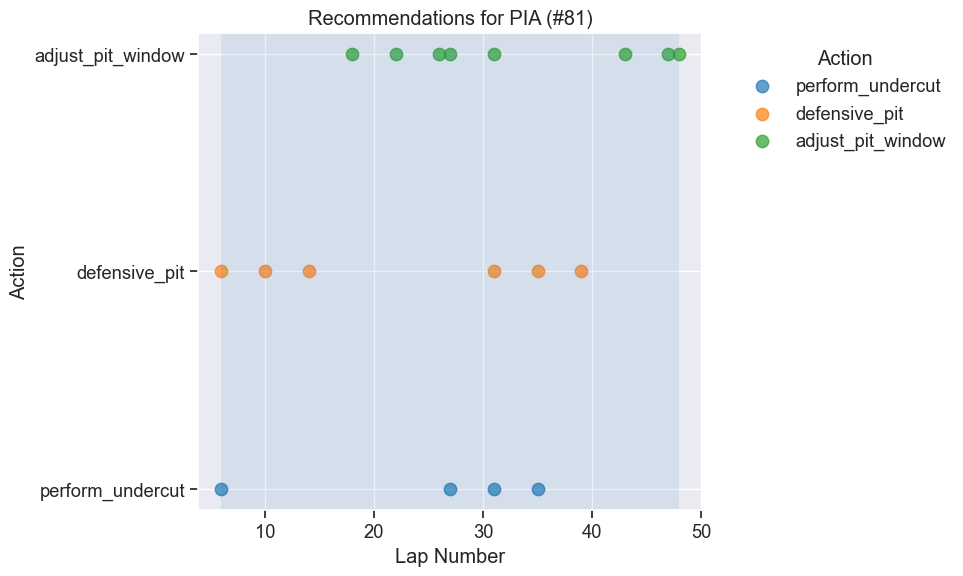

In [21]:
plot_driver_recommendations(81)  # For driver #81


### 7.2 Bar Chart of total recommendations per driver

C:\Users\victo\AppData\Local\Temp\ipykernel_4116\979259281.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='DriverLabel', data=driver_counts, palette='viridis')


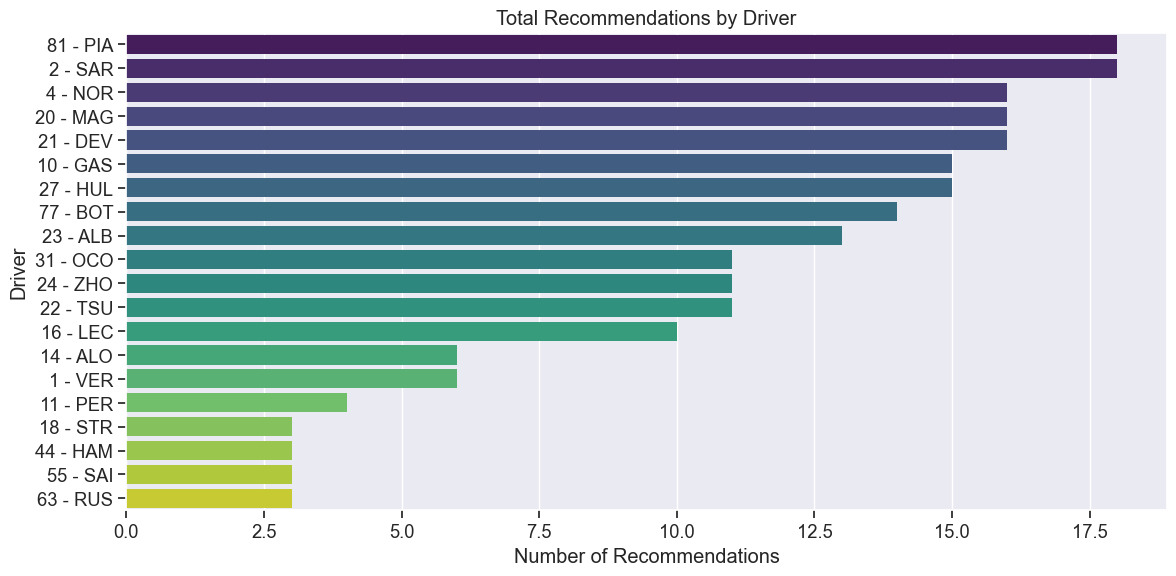

In [22]:
# 2. Bar chart of recommendations per driver
plt.figure(figsize=(12, 6))
driver_counts = recommendations_df.groupby(['DriverNumber', 'DriverName']).size().reset_index(name='count')
driver_counts['DriverLabel'] = driver_counts['DriverNumber'].astype(str) + ' - ' + driver_counts['DriverName']
driver_counts = driver_counts.sort_values('count', ascending=False)

sns.barplot(x='count', y='DriverLabel', data=driver_counts, palette='viridis')
plt.xlabel('Number of Recommendations')
plt.ylabel('Driver')
plt.title('Total Recommendations by Driver')
plt.tight_layout()

# Show the plots
plt.show()




### 7.3 Distribution of the recommendation types done by the agent

C:\Users\victo\AppData\Local\Temp\ipykernel_4116\1779473602.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='action', data=recommendations_df, palette='viridis',


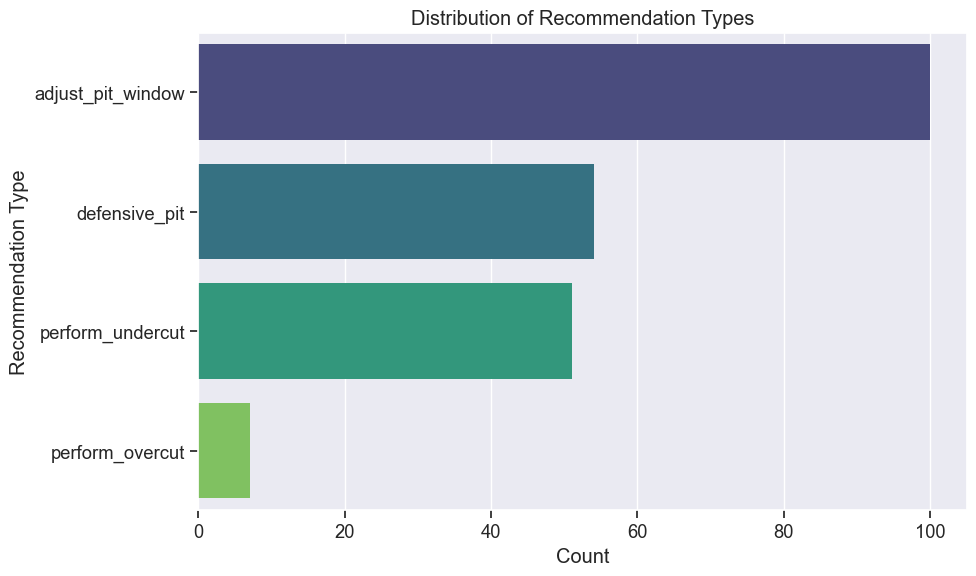

Total recommendations: 212
Unique drivers with recommendations: 20
Lap range: 6 to 48


In [23]:
# 3. Distribution of recommendation types
plt.figure(figsize=(10, 6))
sns.countplot(y='action', data=recommendations_df, palette='viridis',
              order=recommendations_df['action'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Recommendation Type')
plt.title('Distribution of Recommendation Types')
plt.tight_layout()
plt.show()

print(f"Total recommendations: {len(recommendations_df)}")
print(f"Unique drivers with recommendations: {recommendations_df['DriverNumber'].nunique()}")
print(f"Lap range: {recommendations_df['lap_issued'].min()} to {recommendations_df['lap_issued'].max()}")

---

## 8. Achievements and Conclusions of the Notebook

1. **Data Extraction and Processing**
   - Implemented functions to extract precise gap data from FastF1 sessions
   - Developed methods to calculate gaps between cars at specific moments in the race
   - Introduced the concept of "gap consistency," analyzing persistent gap patterns over multiple laps

2. **Expert Rule System**
   - Created the `F1GapRules` class that integrates four core strategic rules:
     - Undercut opportunities when a car follows another closely without overtaking
     - Defensive pit stops when being consistently chased
     - Overcut strategies when in an optimal gap window
     - Traffic management to avoid time loss after pit stops

3. **Strategic Context**
   - Implemented detection of specific strategic windows (early stint: laps 6–26; mid stint: laps 26–48)
   - Updated rules to consider consistent behavior across consecutive laps rather than just instantaneous values
   - Incorporated thresholds derived from analysis of real race data

4. **End-to-End Processing Pipeline**
   - Developed the `analyze_race_gaps` function, which combines all components into a complete workflow
   - Added intelligent filtering of recommendations to prevent information overload
   - Attached key metadata to each recommendation, including driver, team, and situational context

5. **Visualization and Analysis**
   - Created visualizations to clarify and interpret the generated recommendations
   - Performed statistical analysis to uncover patterns in the recommendations

### Real-World Application
This system forms a critical part of our F1 strategy engine, complementing modules for:
- Tire degradation analysis
- Lap time prediction
- Radio communications processing

Together, these components create a decision-support platform capable of real-time deployment in Formula 1, empowering race engineers with data-driven strategic insights.

